# Wafer Map Mixed Type Defect Pattern Multi Class classification

## Problem Statement
To build a Deep Learning based Image Classifier model for Wafer Map Mixed-type Defect Pattern Multi-Label Classification which,
 - Is Less complex (takes less training time)
 - Achieves minimum 90% Overall Accuracy
 - Achieves minimum 90% Precision/Recall/F1-scores for each individual defects


## Machine Learning Process

Machine Learning Workflow used for this project is:

- **Gathering Data**
- **Data Cleaning, Exploratory Data Analysis and Feature Engineering**
- **CNN Model Building, Model Training, Fine Tuning/Hyper Parameter Tuning**
- **Model Evaluation**
- **Deploy the Model**

This notebook will focus on the **Model Evaluation**

Contents of this Notebook:
- Load data
- Preprocess data
- Load the model
- Model Prediction
- Model Evaluation
- Results and Conclusions
- Future Work

In [52]:
#Install Libraries
!pip install scikit-multilearn -q
!pip install tensorflow-addons

In [53]:
#Working Directory
!pwd

/content


In [100]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.set_palette("viridis")

from numpy import arange
from collections import Counter
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, cohen_kappa_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc

from skmultilearn.model_selection import IterativeStratification
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

from IPython.display import clear_output
from six.moves import urllib
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Activation, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy, BinaryAccuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

import zipfile
import os

from skimage import color
from skimage import io

!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

import skimage.io 
import skimage.segmentation

TF version: 2.7.0
TF Hub version: 0.12.0
     |████████████████████████████████| 275 kB 9.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=0343307f83cc4da366d55c3ab235d2759e58d83482b022818c6cc9f5bf056c50
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [55]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [56]:
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESSSS!!!!!)


In [57]:
os.environ['DIR'] = "/content"

### Loading data
- From the Github repo

In [58]:
#Clone the github repo where the data is stored
!git clone 'https://github.com/shaashaa/WaferMap_DefectClassification.git'

fatal: destination path 'WaferMap_DefectClassification' already exists and is not an empty directory.


In [59]:
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("WaferMap_DefectClassification/Data/Wafer_Map_Datasets.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [60]:
dataset = np.load('/content/Wafer_Map_Datasets.npz', encoding='bytes') #to run in google colab
# dataset = np.load('./Data/Wafer_Map_Datasets.npz', encoding='bytes') #to run in Jupyter notebook

In [61]:
print(dataset.files)

['arr_0', 'arr_1']


### Preprocessing the data

- For more details refer to the **Preprocessing_Modelling.ipynb** Notebook

In [62]:
#Print the shape of the Image and Labels array
print(dataset['arr_0'].shape, dataset['arr_1'].shape)

(38015, 52, 52) (38015, 8)


In [63]:
# Assign Image data to X  & label data to y
X = dataset['arr_0']
y = dataset['arr_1']

In [64]:
#Replace invalid pixel value 3 to 1
X[X > 2] = 1

In [65]:
#Normalising Image pixel values by dividing the image by the pixel maximum value
X = X/2.0

In [66]:
#Creating a function to do the Stratified Split (Train-Validation-Test)
def iterative_train_test_split(X, y, train_size):
    stratifier = IterativeStratification(n_splits=2, order=1, 
                            sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [67]:
#50% for Train split, 25% for validataion split and 25% for Test split
X_train, X_, y_train, y_ = iterative_train_test_split(
    X, y, train_size=0.5)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [68]:
#Created an RGB representation of a gray-level image
X_train = color.gray2rgb(X_train)
X_val = color.gray2rgb(X_val)
X_test = color.gray2rgb(X_test)

In [70]:
#Function to Calculate Hamming Loss
def Hamming_Loss(y, ypred):
  temp=0
  for i in range(y.shape[0]):
    temp += np.size(y[i] == ypred[i]) - np.count_nonzero(y[i] == ypred[i])
  return temp/(y.shape[0] * y.shape[1])

### Load the Model

#### Load the model structure from JSON file and Model Weights from HDF5 file

In [73]:
# load the saved model
#Load JSON file 
json_file = open("final_model.json", 'r') #WaferMap_DefectClassification/final_model.json", 'r')
defect_model_json = json_file.read()
json_file.close()
defect_model = model_from_json(defect_model_json)

# Loading h5 file
defect_model.load_weights("final_model_weights.h5") #WaferMap_DefectClassification/final_model_weights.h5")

#### Plot Model Architecture

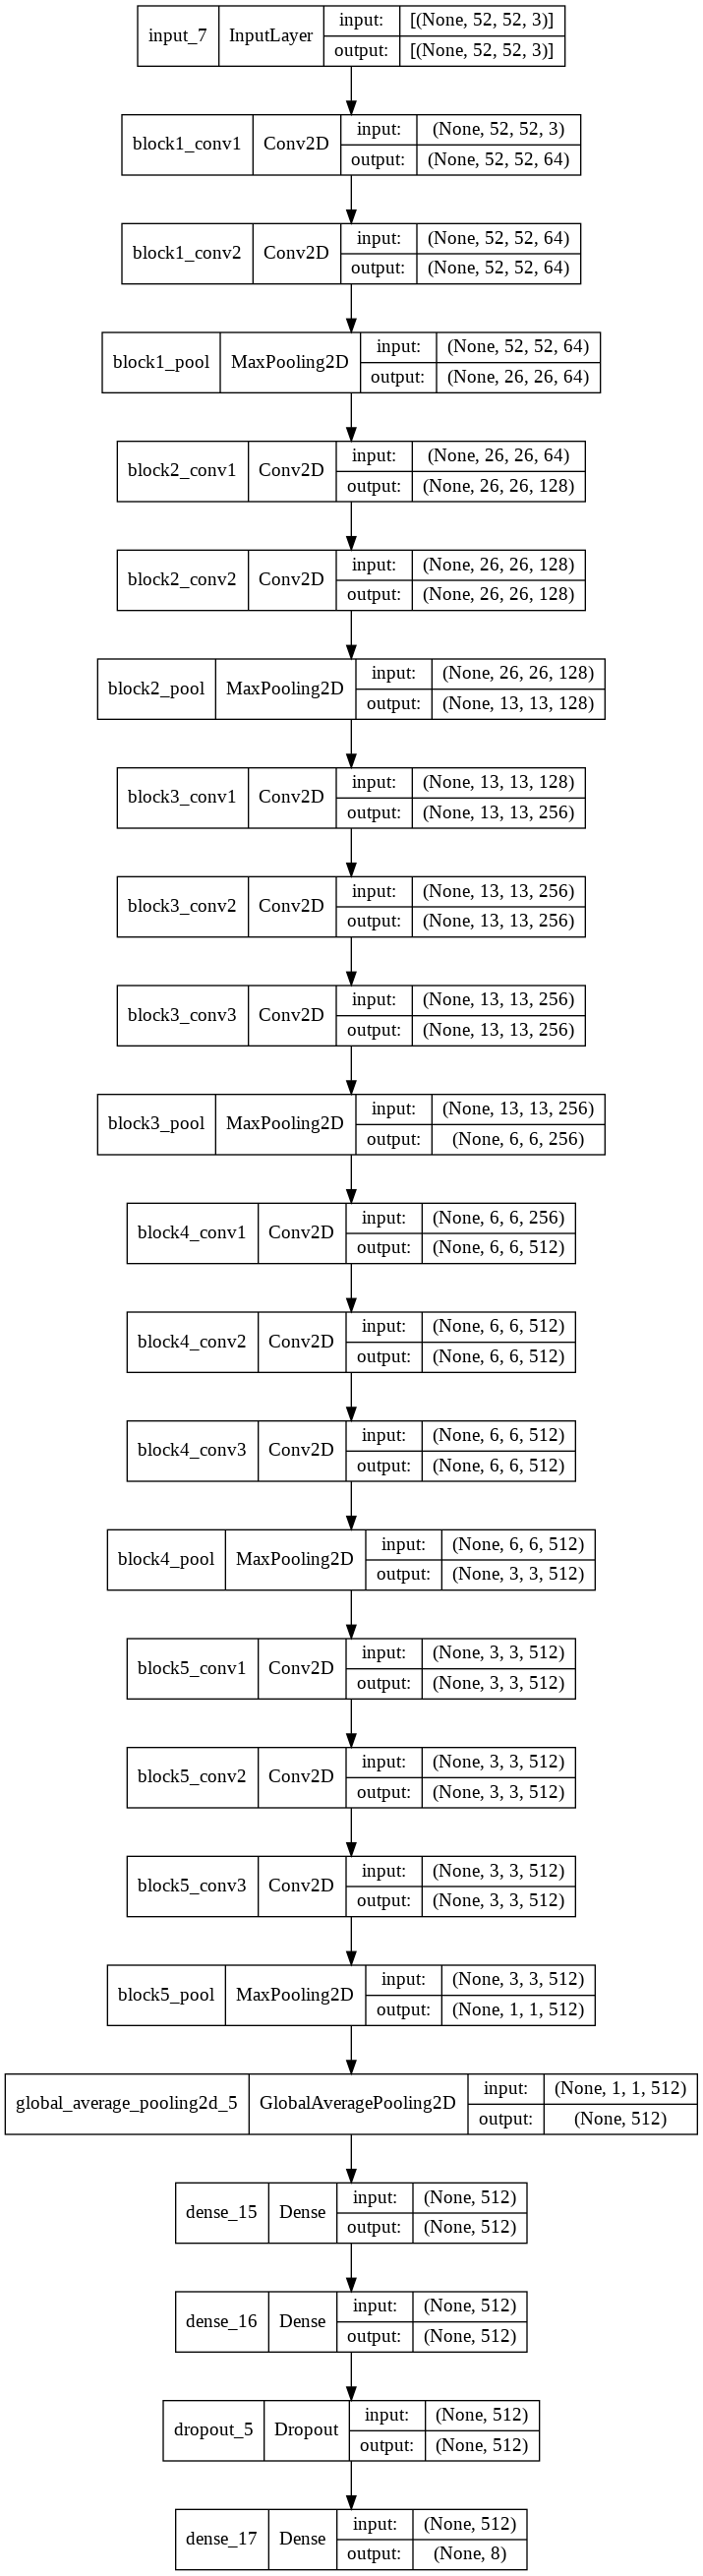

In [111]:
#Model Architecture: VGG16 base model + GlobalAveragePooling2D + 2 Fully connected Layers + Drop Out Layer + Output Dense Layer with Sigmoid Activation
plot_model(defect_model, to_file='defect_model_plot.png', show_shapes=True, show_layer_names=True)

#### Perform Model Prediction on Train, Test and Validataion data sets
- Probability threshold: 0.5

In [74]:
#Train, Test & Validation set Prediction
ytrain_pred = defect_model.predict(X_train)
yval_pred = defect_model.predict(X_val)
ytest_pred = defect_model.predict(X_test)

#threshold for prediction
threshold = 0.5
ytrain_pred = np.where(ytrain_pred > threshold, 1, 0)
yval_pred = np.where(yval_pred > threshold, 1, 0)
ytest_pred = np.where(ytest_pred > threshold, 1, 0)

### Model Evaluation
- Evaluation Metrics for overall perforance: AccuracyScore/Exact Match Ratio and Hamming Loss
  - [Exact Match Ratio: Percentage of samples that have all their labels classified correctly.](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)
  - [Hamming-Loss: Fraction of labels that are incorrectly predicted](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff)

- Evaluation Metrics for Individual defects: Precision/Recall/F1 score and ROC_AUC score

In [75]:
#Overall Evaluation

#Exact Match Ratio
MR_train = np.all(ytrain_pred == y_train, axis=1).mean()
MR_val = np.all(yval_pred == y_val, axis=1).mean()
MR_test = np.all(ytest_pred == y_test, axis=1).mean()
print('Exact Match Ratio: Train = {}, Val = {}, Test = {}'.format(MR_train, MR_val, MR_test))

#Hamming Loss    
HL_train = Hamming_Loss(y = y_train, ypred = ytrain_pred)
HL_val = Hamming_Loss(y = y_val, ypred = yval_pred)
HL_test = Hamming_Loss(y = y_test, ypred = ytest_pred)
print('Hamming Loss: Train = {}, Val = {}, Test = {}'.format(HL_train, HL_val, HL_test))

Exact Match Ratio: Train = 0.9574367338349029, Val = 0.9529671717171717, Test = 0.9544402356902357
Hamming Loss: Train = 0.006865891513652865, Val = 0.007207491582491583, Test = 0.006931292087542088


- Higher ExactMatchRatio and Smaller Hamming loss shows that the performance of the model is good

Confusion Matrix of Each Individual Defects
-------------------------------------------


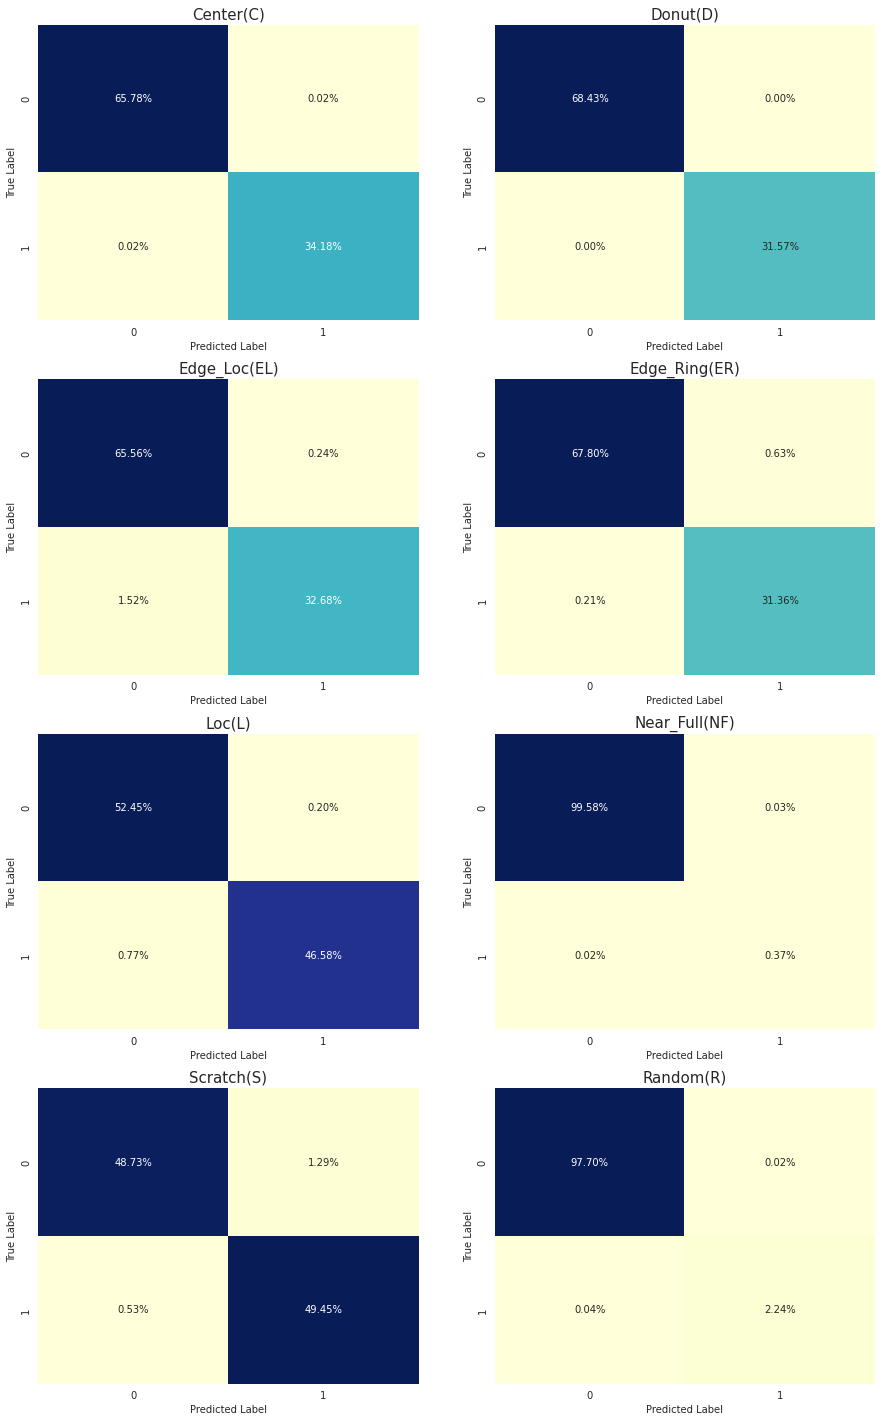

In [76]:
confusion_mat = multilabel_confusion_matrix(y_test, ytest_pred.round())

#8 single individual defects in the Labels
Labels = ['Center(C)', 'Donut(D)', 'Edge_Loc(EL)', 'Edge_Ring(ER)', 'Loc(L)', 'Near_Full(NF)', 'Scratch(S)', 'Random(R)']

# Plotting one Sample Image for each of the Mixed Type pattern (With Normal/No defect, Single defect, Multiple defects) 
print('Confusion Matrix of Each Individual Defects')
print('-------------------------------------------')
fig, ax = plt.subplots(4, 2,figsize=(15, 25))
row = 0
col = 0

for i in range(len(Labels)):
    cf_matrix = confusion_mat[i]
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='YlGnBu', ax = ax[row, col], cbar=False)
    ax[row, col].grid(False)
    ax[row, col].set_title(Labels[i], fontsize=15)
    ax[row, col].set_xlabel('Predicted Label')
    ax[row, col].set_ylabel('True Label')
    if col==1:
        col = 0
        row += 1
    else:
        col +=1

- Confusion Matrix clearly shows that the False Postive and False Negative are less than 1% for all the individual defects




In [77]:
report = classification_report(y_train, ytrain_pred.round(), target_names=Labels, output_dict=True)
print('Classification report for Train set')
print('----------------------------------')
pd.DataFrame(report).T

Classification report for Train set
----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Center(C),0.999078,1.000000,0.999539,6500.0
Donut(D),1.000000,1.000000,1.000000,6000.0
Edge_Loc(EL),0.992432,0.948154,0.969788,6500.0
Edge_Ring(ER),0.974296,0.991833,0.982986,6000.0
Loc(L),0.997194,0.987333,0.992239,9000.0
Near_Full(NF),0.839080,0.973333,0.901235,75.0
Scratch(S),0.979420,0.991895,0.985618,9500.0
Random(R),0.995227,0.963048,0.978873,433.0
micro avg,0.989763,0.986480,0.988119,44008.0
macro avg,0.972091,0.981950,0.976285,44008.0


In [78]:
report = classification_report(y_val, yval_pred.round(), target_names=Labels, output_dict=True)
print('Classification report for Validation set')
print('----------------------------------')
pd.DataFrame(report).T

Classification report for Validation set
----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Center(C),0.999078,1.000000,0.999539,3250.0
Donut(D),1.000000,1.000000,1.000000,3000.0
Edge_Loc(EL),0.994186,0.947077,0.970060,3250.0
Edge_Ring(ER),0.973865,0.993667,0.983666,3000.0
Loc(L),0.995053,0.983333,0.989158,4500.0
Near_Full(NF),0.947368,0.972973,0.960000,37.0
Scratch(S),0.977565,0.990737,0.984107,4750.0
Random(R),0.995327,0.986111,0.990698,216.0
micro avg,0.989326,0.985729,0.987524,22003.0
macro avg,0.985305,0.984237,0.984653,22003.0


In [79]:
report = classification_report(y_test, ytest_pred.round(), target_names=Labels, output_dict=True)
print('Classification report for Test set')
print('----------------------------------')
pd.DataFrame(report).T

Classification report for Test set
----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Center(C),0.999385,0.999385,0.999385,3250.0
Donut(D),1.000000,1.000000,1.000000,3000.0
Edge_Loc(EL),0.992649,0.955692,0.973820,3250.0
Edge_Ring(ER),0.980263,0.993333,0.986755,3000.0
Loc(L),0.995726,0.983778,0.989716,4500.0
Near_Full(NF),0.921053,0.945946,0.933333,37.0
Scratch(S),0.974497,0.989474,0.981928,4750.0
Random(R),0.990698,0.981567,0.986111,217.0
micro avg,0.989426,0.986593,0.988008,22004.0
macro avg,0.981784,0.981147,0.981381,22004.0




*   Precision/Recall/F1-score is >90% for all the Individual defects including the Near_Full and Random defects which has less counts



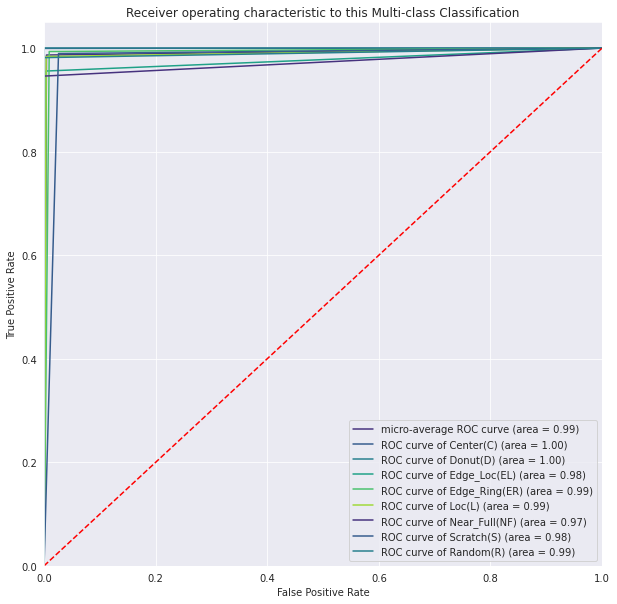

In [96]:
# Calculating ROC curve and ROC area for each of the individual defects
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ytest_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), ytest_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(8):
        plt.plot(fpr[i], tpr[i], label='ROC curve of {0} (area = {1:0.2f})'''.format(Labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to this Multi-class Classification')
plt.legend(loc="lower right")
plt.show()

*  ROC_AUC is > 95% for all the Individual defects including the Near_Full and Random defects which has less counts

In [97]:
#Function to output defect name for the Labels
def label_to_text(label):
  text = " "
  if label[0] == 1:
    text = text + str("C ")
  if label[1] == 1:
    text = text + str("D ")
  if label[2] == 1:
    text = text + str("EL ")
  if label[3] == 1:
    text = text + str("ER ")
  if label[4] == 1:
    text = text + str("L ")
  if label[5] == 1:
    text = text + str("NF ")
  if label[6] == 1:
    text = text + str("S ")
  if label[7] == 1:
    text = text + str("R ")
  return text

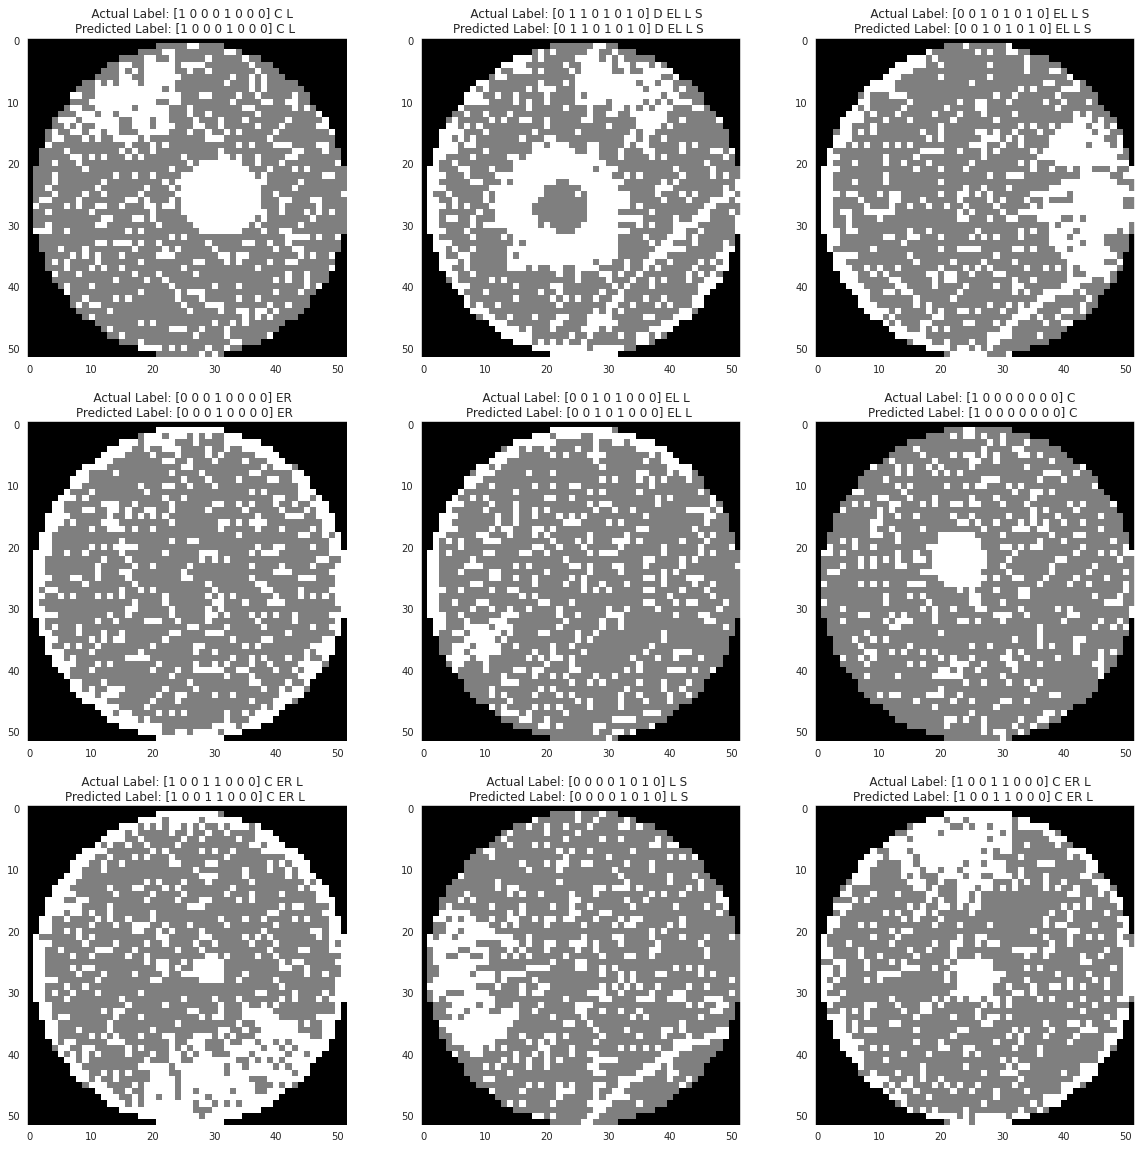

In [99]:
# Plotting Sample Prediction 

#List of random integers - to pick random image
ind = []
for i in range(0,9):
  ind.append( random.randint(0, X_test.shape[0])) 

#Plot Image and Print the Actual and Predicted values
fig, ax = plt.subplots(3, 3, figsize= (20, 20))
row = 0
col = 0

for i in range(len(ind)):
    #Image
    data = np.ndarray(shape=(1, 52, 52, 3), dtype=np.float32)
    img = X_test[ind[i]]
    data[0] = img

    #Actual Value
    label_true = y_test[ind[i]]

    #Predicted Value
    label_prob = defect_model.predict(data)
    label_pred = (np.where(label_prob > 0.5, 1, 0))[0]

    #Add in the Label to the Actual and Predicted
    #Print this on the title of the image
    title_true = "     Actual Label: " + str(label_true) + label_to_text(label_true)
    title_pred = "Predicted Label: " + str(label_pred) + label_to_text(label_pred.tolist())
    title = title_true + str(' \n') + title_pred

    #Plotting Image with title
    ax[row, col].imshow(img)
    ax[row, col].grid(False)
    ax[row, col].set_title(title, fontsize=12)
    if row==2:
        row = 0
        col += 1
    else:
        row +=1

#Save the Plot
plt.savefig('Sample_Prediction.png')




*   Above Images clearly shows that True labels and Predicted Labels are accurate for different defects and mixed patterns too





## Interpreting the Image Classification Model using LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

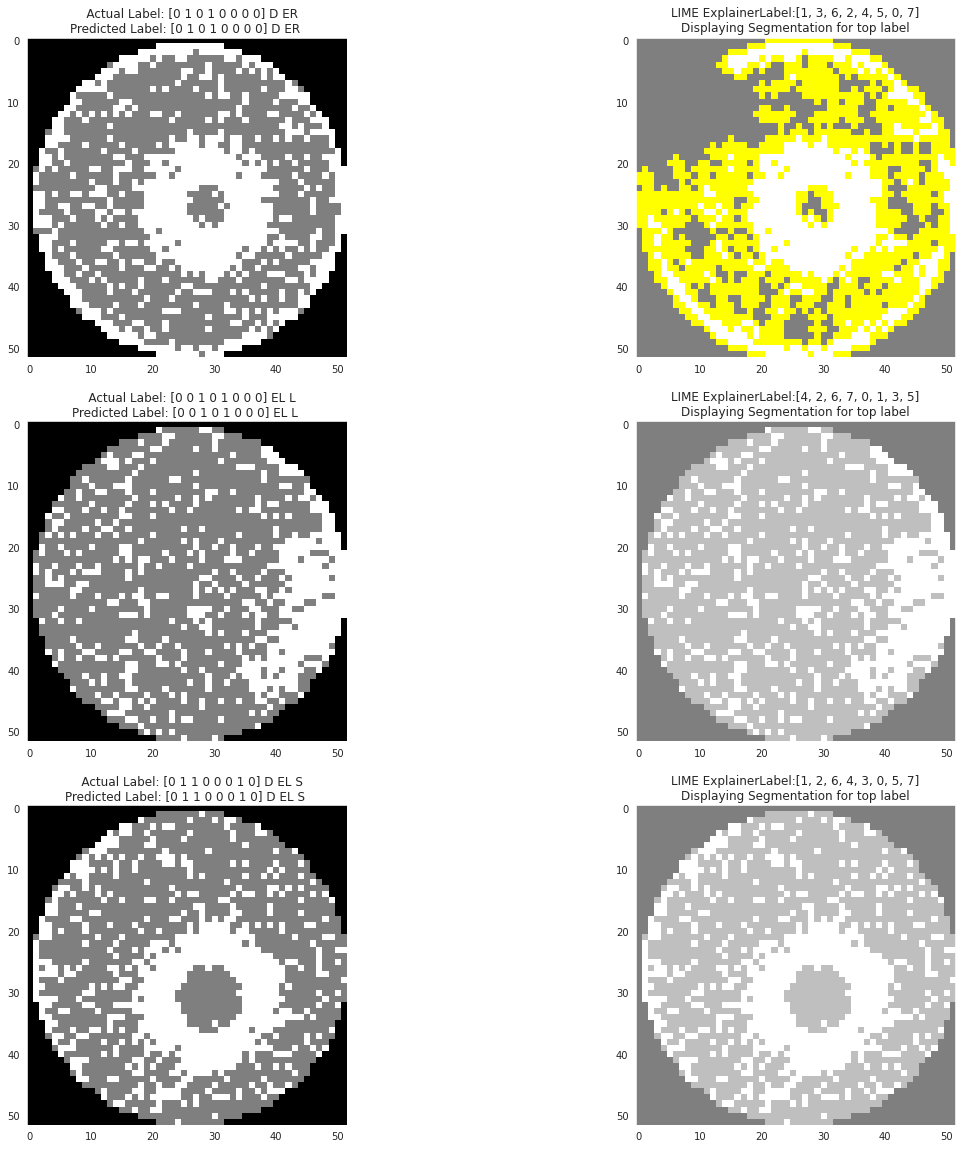

In [108]:
#Generating 3 random index numbers to selecting the Images
ind = []
for i in range(0,3):
  ind.append( random.randint(0, X_test.shape[0])) 

#Plot Image and Print the Actual and Predicted values
fig, ax = plt.subplots(3, 2, figsize= (20, 20))
row = 0
col = 0

for i in range(len(ind)):
    #Image data
    data = np.ndarray(shape=(1, 52, 52, 3), dtype=np.float32)
    img = X_test[ind[i]]
    data[0] = img

    #LIME explainer
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(X_test[ind[i]].astype('double'), defect_model.predict, top_labels=8, hide_color=0)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=8, hide_rest=True)

    #Actual Value
    label_true = y_test[ind[i]]

    #Predicted Value
    label_prob = defect_model.predict(data)
    label_pred = (np.where(label_prob > 0.5, 1, 0))[0]

    #Add in the Label to the Actual and Predicted
    #Print this on the title of the image
    title_true = "     Actual Label: " + str(label_true) + label_to_text(label_true)
    title_pred = "Predicted Label: " + str(label_pred) + label_to_text(label_pred.tolist())
    title = title_true + str(' \n') + title_pred

    #Plotting Actual Image
    ax[i, 0].imshow(img)
    ax[i, 0].grid(False)
    ax[i, 0].set_title(title, fontsize=12)

    #Plotting Segmantation Mark Image
    ax[i, 1].imshow(skimage.segmentation.mark_boundaries(temp / 2 + 0.5, mask))
    ax[i, 1].grid(False)
    ax[i, 1].set_title(('LIME ExplainerLabel:'+str(explanation.top_labels)+'\nDisplaying Segmentation for top label'), fontsize=12)

#Save the Plot
plt.savefig('LIMEexplanation.png')

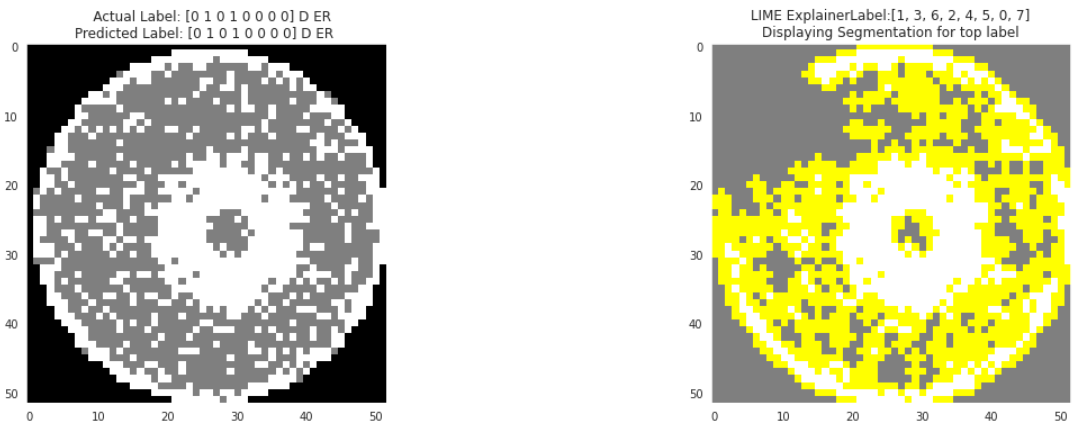
*  In Image top label is the Donut(D)
*  LIME Segmentation Image on the right clearly shows that the model is able to identify the shape of the Donut(D) well and so can predict it correctly

# Results and Conclusions


*   The Multi-Label Classification model developed with VGG16 architecture is Classifying the Mixed-Type Defect Pattern of the WaferMap with the over all AccuracyScore/ExactMatchRatio of 95% and Hamming loss very low (~0.006%) on the Test set
*   False Positives and False Negatives are less than 1% for all the Individual defects (classes)
*   Achieved Precision/Recall/F1-score > 90% for each of the Individual defects indcuding the defect with less count
*   LIMEexplanier segmentation masks shows that the model is able to identify the shape of the pattern well



# Future Work


*   As the complexity of the process keep increasing constantly with the advancement in technology, there are high possibility to encounter new defect patterns. So as a future work plan to develop Image segmentation model to detect new patterns and integrate with the Multi-Label Classification model

